# Prediction Demonstration

This notebook demonstrates the segmentation and hidden part reconstruction of bubbles in 2D images using StarDist and RDC models.

**Key Workflows:**
1. **Model Loading**: Loads StarDist and RDC models from the `Models` directory.
2. **Prediction**: Performs segmentation using `createLabelUNet` and `combinedPrediction`.
3. **Reconstruction**: Recovers hidden bubble parts using RDC method or ellipse fitting.
4. **Visualization**: Displays original images, segmentation masks, and reconstructed bubbles.

**Input**: `Examples`
**Output**: Visualization figures.

In [ ]:
from stardist.matching import matching_dataset
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
from utils_Segmentation import createLabelUNet,combinedPrediction,load_img,load_MXNet
from csbdeep.utils import normalize
import mxnet as mx
from stardist.models import StarDist2D
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from utils_StarBub import HiddenReco,SaveCSV_List
from tqdm import tqdm
from stardist import random_label_cmap
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
%matplotlib notebook
plt.ion()
%config InlineBackend.figure_format = 'retina'

lbl_cmap=random_label_cmap()

## Model Loading & Settings
The models are expected to be in the Models directory situated in the same directory as the notebook. Otherwise the Model_dir needs to be changed. Using GPU is recommend for computational speed.

In [2]:
base_dir=os.path.abspath('')
Model_dir=base_dir+'/Models/'
use_gpu=False # Switch off to use CPU (slower prediction)
# model_path = r'd:\Final_Uni\Project_StarDist\Software\CodeRepo\Models\RDCModel.keras'


if use_gpu:
    ctx=mx.gpu(0)
    physical_devices=tf.config.list_physical_devices('GPU')
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device,True)
else:
    ctx=mx.cpu(0) 
    os.environ['CUDA_VISIBLE_DEVICES']='-1'

modelSD =StarDist2D(None, name='stardist', basedir=Model_dir+'SDmodel')
netMask,netInter=load_MXNet(Model_dir,ctx,"_512")
model = tf.keras.models.load_model(Model_dir+'RDCModel')
# model = tf.keras.models.load_model(Model_dir+'RDCModel.h5')
# model = tf.keras.models.load_model(model_path)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.484532, nms_thresh=0.3.


In [3]:
print(tf.__version__)

2.4.0


In [4]:
model.summary()
model.input_shape


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
Total params: 16,640
Trainable params: 16,640
Non-trainable params: 0
_________________________________________________________________


(None, 64)

### Example: Predict on a single image
The example shows how to predict bubbles by first predicting the segmentations mask with the 'createLabelUNet' and 'combinedPrediction' functions. Afterwards the hidden bubble parts are reconstructed either with the RDC method or by ellipse fitting.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of yhat:  (1, 64)
yhat:  [0.00227416 0.00239394 0.00252213 0.00266775 0.00266051 0.00254437
 0.00232186 0.00209865 0.00186786 0.00164912 0.00150385 0.00137366
 0.00126528 0.0012126  0.00115588 0.00113811 0.00111384 0.00111903
 0.0011124  0.00117765 0.00123575 0.00132048 0.00142966 0.00158359
 0.00174579 0.00196916 0.00221522 0.00245491 0.00259199 0.00260599
 0.00248035 0.00231395 0.00217852 0.00209887 0.00204284 0.00197854
 0.00189978 0.00185529 0.00179456 0.00178886 0.0017298  0.00170912
 0.00167642 0.00164601 0.00160126 0.00161455 0.00158378 0.0015789
 0.00155327 0.00156728 0.00157757 0.00157904 0.00159405 0.00162737
 0.0016515  0.00168826 0.00171313 0.00177624 0.0018238  0.00188539
 0.00193219 0.00201627 0.00207584 0.00214743]


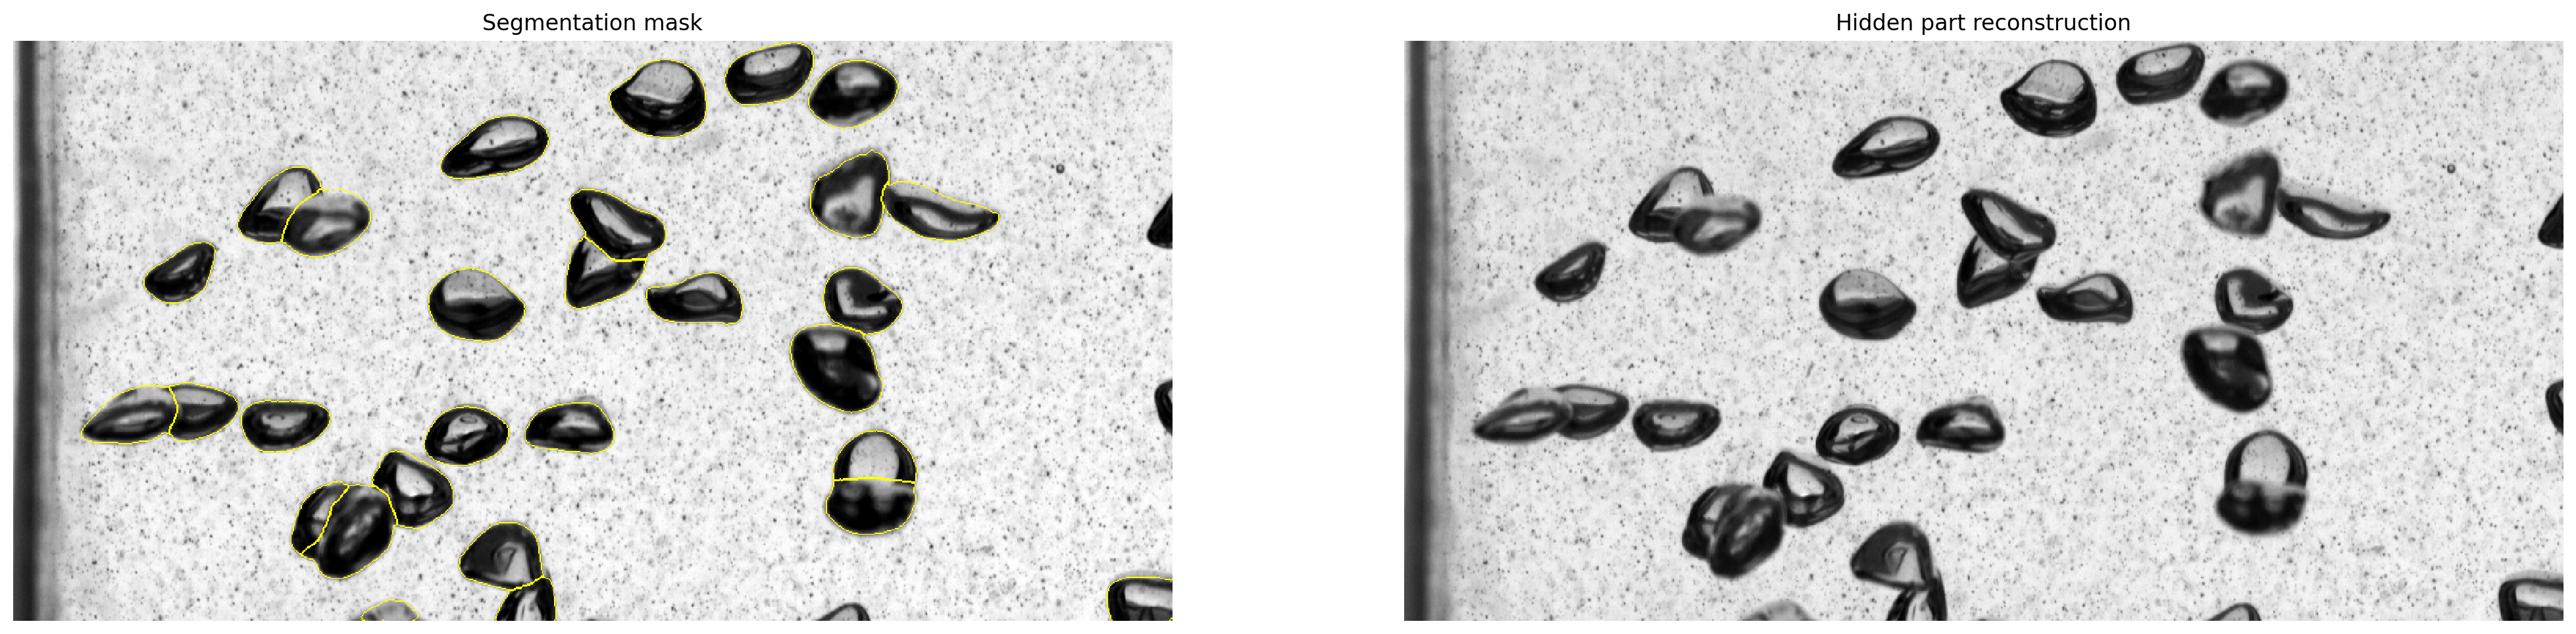

shape of yhat:  (1, 64)
yhat:  [0.00237755 0.00229469 0.00223709 0.00225021 0.002215   0.00216249
 0.00208946 0.00210865 0.00208238 0.00206077 0.00209809 0.00212629
 0.002151   0.00223718 0.00227396 0.00235749 0.00242589 0.00250424
 0.00256295 0.00267866 0.00276156 0.0028894  0.00299335 0.00305218
 0.00309454 0.00316068 0.00323845 0.00338934 0.00349513 0.00367242
 0.00383721 0.00401309 0.00410485 0.00414951 0.00408686 0.00393882
 0.00380318 0.00370532 0.00355464 0.00348199 0.00331624 0.00319281
 0.00310625 0.00301794 0.00293914 0.00294954 0.00285296 0.00283649
 0.00281197 0.00283708 0.00284614 0.0028493  0.00288464 0.00290342
 0.00291365 0.00293512 0.00288187 0.00286193 0.00280348 0.00271141
 0.00262552 0.00258931 0.00251052 0.00242089]
shape of yhat:  (1, 64)
yhat:  [0.00253137 0.00246148 0.00234685 0.00227684 0.00214656 0.00204462
 0.00192375 0.00187048 0.00179206 0.0017029  0.00165433 0.00160547
 0.00155435 0.00154466 0.00152087 0.00152015 0.00151778 0.00153031
 0.00153695 0.0016102

In [5]:
from skimage.segmentation import mark_boundaries
Metric=6.7E-5 # Size of an image pixel in m 
boolplot=True # Use this for visual inspection.
useRDC=True # Switch on to use the RDC method, otherwise ellipse fitting will be used.

ImgDir=base_dir+'/Examples/65.tif'

x=load_img(ImgDir)
X=normalize(x if x.ndim==2 else x[...,0], 1,99.8, axis=(0,1))
imgMask,imgIntersec=createLabelUNet(X,2,netMask,512,300,ctxMask=ctx)
labels,_=combinedPrediction(X,modelSD,imgMask,imgIntersec)
# labels,_=modelSD.predict_instances(X,verbose=False)
if boolplot:
    if useRDC==False:
        %config InlineBackend.print_figure_kwargs={'bbox_inches': None}
    else:
        %config InlineBackend.print_figure_kwargs={'bbox_inches': 'tight'}        
    _, (ax2,ax3) = plt.subplots(1,2,figsize=(25,25))
    # ax1.imshow(X,cmap='gray');ax1.imshow(imgMask,cmap='Reds',alpha=0.5)
    # ax1.imshow(mark_boundaries(X, labels))
    # ax1.set_axis_off()
    # ax1.set_title('UNet mask')
    ax2.imshow(X,cmap='gray')
    # ax2.imshow(labels,cmap=lbl_cmap,alpha=0.5)
    ax2.imshow(mark_boundaries(X, labels))
    ax2.set_axis_off()
    ax2.set_title('Segmentation mask')
    ax3.imshow(X,cmap='gray')
    ax3.set_axis_off() 
    ax3.set_title('Hidden part reconstruction')   
Bubbles=HiddenReco(labels,Metric,useRDC=useRDC,model=model,boolPlot=boolplot,ax=ax3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



=== DIỆN TÍCH CÁC BỌT KHÍ ===
Bọt khí   1:     0.92 mm² ( 924734.00 µm²)
Bọt khí   2:     2.34 mm² (2343258.00 µm²)
Bọt khí   3:     1.36 mm² (1360167.00 µm²)
Bọt khí   4:     1.30 mm² (1297321.00 µm²)
Bọt khí   5:     2.24 mm² (2240011.00 µm²)
Bọt khí   6:     2.03 mm² (2029028.00 µm²)
Bọt khí   7:     1.25 mm² (1247942.00 µm²)
Bọt khí   8:     1.21 mm² (1212030.00 µm²)
Bọt khí   9:     2.29 mm² (2293879.00 µm²)
Bọt khí  10:     2.75 mm² (2751757.00 µm²)
Bọt khí  11:     2.52 mm² (2522818.00 µm²)
Bọt khí  12:     2.31 mm² (2311835.00 µm²)
Bọt khí  13:     2.51 mm² (2513840.00 µm²)
Bọt khí  14:     1.25 mm² (1252431.00 µm²)
Bọt khí  15:     0.87 mm² ( 866377.00 µm²)
Bọt khí  16:     3.17 mm² (3169234.00 µm²)
Bọt khí  17:     3.23 mm² (3232080.00 µm²)
Bọt khí  18:     1.13 mm² (1126739.00 µm²)
Bọt khí  19:     2.12 mm² (2118808.00 µm²)
Bọt khí  20:     1.73 mm² (1732754.00 µm²)
Bọt khí  21:     2.03 mm² (2029028.00 µm²)
Bọt khí  22:     1.78 mm² (1777644.00 µm²)
Bọt khí  23:     0.90 m

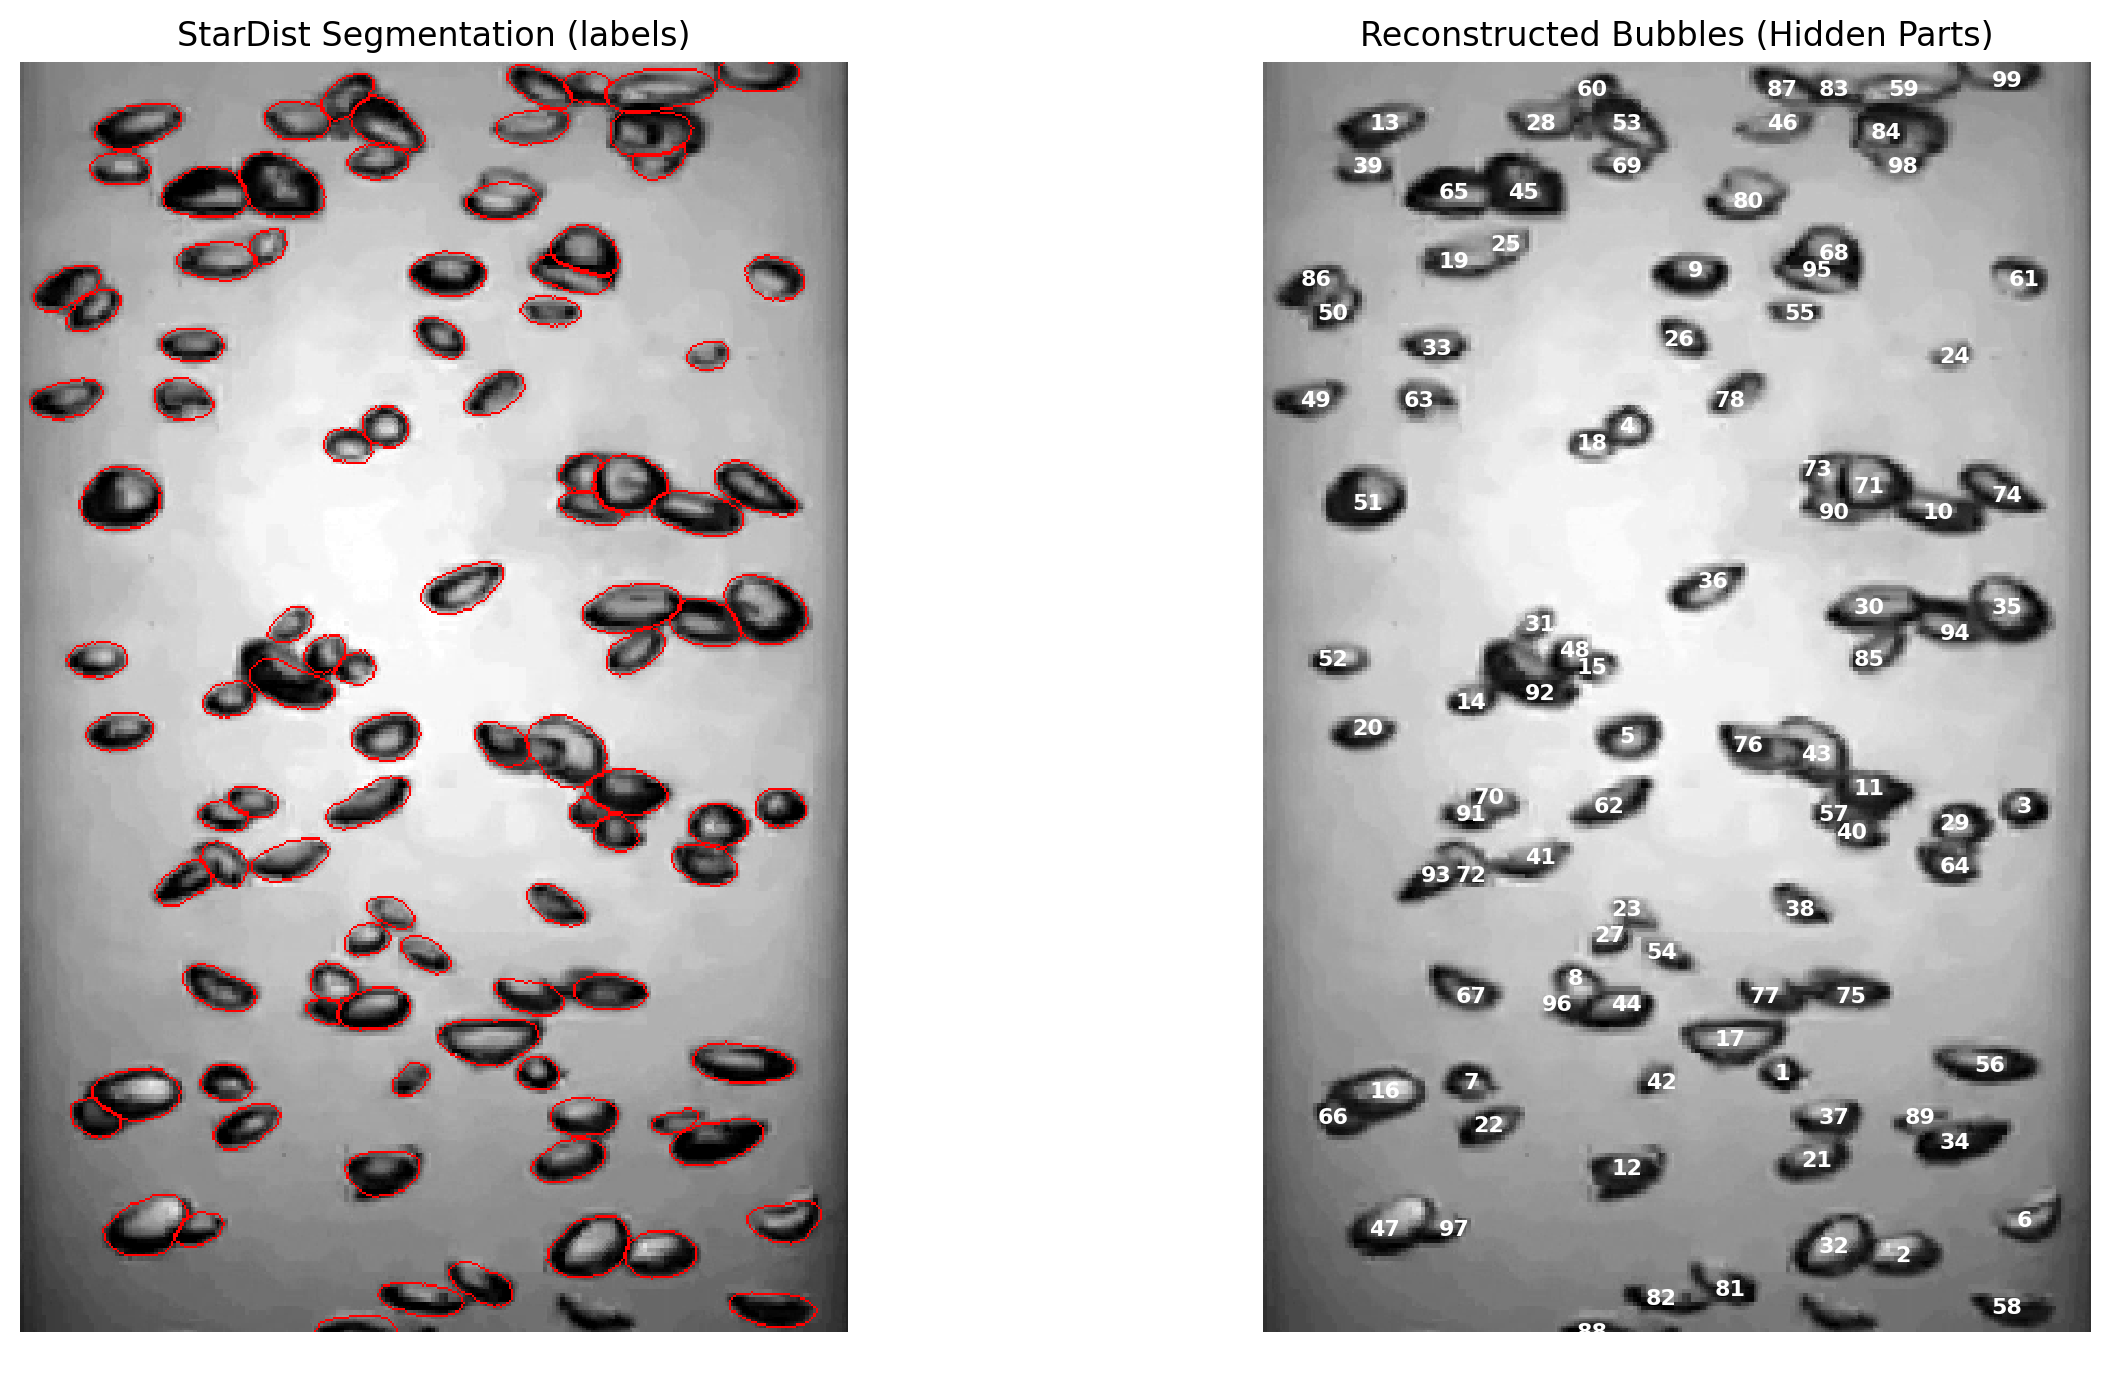

In [ ]:
import numpy as np
from skimage.draw import polygon
from skimage.segmentation import mark_boundaries
from matplotlib.patches import Polygon as MatplotlibPolygon



# Main code
Metric=6.7E-5 # Size of an image pixel in m 
boolplot=True # Use this for visual inspection.
useRDC=True # Switch on to use the RDC method, otherwise ellipse fitting will be used.

ImgDir=base_dir+'/Examples/43.tif'

x=load_img(ImgDir)
X=normalize(x if x.ndim==2 else x[...,0], 1,99.8, axis=(0,1))
labels,details=modelSD.predict_instances(X,verbose=False)

coords = details["coord"]      # danh sách polygon
points = details["points"]     # tâm các bubble


# -----------------------------
# 4. Vẽ kết quả
# -----------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# ----- (A) ẢNH SEGMENTATION -------
ax[0].set_title("StarDist Segmentation (labels)")
ax[0].imshow(mark_boundaries(X, labels, color=(1, 0, 0)))
ax[0].axis("off")


# ----- (B) ẢNH RECONSTRUCT POLYGON -------
ax[1].set_title("Reconstructed Bubbles (Hidden Parts)")
ax[1].imshow(X, cmap="gray")

# Sử dụng HiddenReco để tái tạo các phần bị che khuất của bọt khí
# HiddenReco sẽ vẽ trực tiếp lên ax[1] nếu boolPlot=True
# Bubbles = HiddenReco(labels, Metric, useRDC=useRDC, model=model, 
#                      boolPlot=boolplot, ax=ax[1])

# print(f"Successfully reconstructed {len(Bubbles)} bubbles")

# Thêm số label vào tâm mỗi bubble
# Sử dụng points từ StarDist nếu có, nếu không sẽ tính từ polygon sau
if points is not None and len(points) > 0:
    # Sử dụng points từ StarDist
    for idx, center_point in enumerate(points):
        label_id = idx + 1
        # StarDist points thường là (y, x), cần đổi thành (x, y) cho matplotlib
        if len(center_point) >= 2:
            x_center = center_point[1]  # cột (x)
            y_center = center_point[0]  # hàng (y)
            # Vẽ số với màu trắng, font đậm, có viền đen để dễ nhìn
            ax[1].text(x_center, y_center, str(label_id), 
                      fontsize=8, fontweight='bold',
                      color='white', ha='center', va='center',
                      )

ax[1].axis("off")

# ==================== TÍNH DIỆN TÍCH CÁC BỌT KHÍ ====================
def calculate_polygon_area(polygon_coords, metric):
    """Tính diện tích polygon bằng công thức Shoelace"""
    if len(polygon_coords) < 3:
        return 0.0
    x = polygon_coords[:, 1]  # cột (x)
    y = polygon_coords[:, 0]  # hàng (y)
    area_pixels = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    area_m2 = area_pixels * (metric ** 2)
    return area_m2

def calculate_area_from_labels(labels, label_id, metric):
    """Tính diện tích từ segmentation mask (đếm số pixel)"""
    pixel_count = np.sum(labels == label_id)
    area_m2 = pixel_count * (metric ** 2)
    return area_m2

# Xử lý coords để có đúng shape (N, M, 2) thay vì (N, 2, M)
if isinstance(coords, np.ndarray) and coords.ndim == 3:
    if coords.shape[1] == 2 and coords.shape[2] >= 2:
        # Shape (N, 2, M) - cần transpose thành (N, M, 2)
        coords_list = [coords[i].T for i in range(coords.shape[0])]
    elif coords.shape[2] == 2:
        # Shape (N, M, 2) - đã đúng
        coords_list = [coords[i] for i in range(coords.shape[0])]
    else:
        coords_list = []
else:
    coords_list = [np.array(p) for p in coords] if isinstance(coords, (list, tuple)) else []

# Tính diện tích cho mỗi bọt khí
bubble_areas = []
bubble_info = []

print("\n" + "="*60)
print("=== DIỆN TÍCH CÁC BỌT KHÍ ===")
print("="*60)

for idx, poly in enumerate(coords_list):
    poly = np.array(poly)
    if len(poly) > 0 and poly.ndim == 2 and poly.shape[1] >= 2:
        valid_mask = ~(np.isnan(poly[:, 0]) | np.isnan(poly[:, 1]) | 
                      np.isinf(poly[:, 0]) | np.isinf(poly[:, 1]))
        poly_valid = poly[valid_mask]
        
        if len(poly_valid) >= 3:
            area_from_polygon = calculate_polygon_area(poly_valid, Metric)
            label_id = idx + 1
            
            # Tính tâm từ polygon (phương án dự phòng nếu points không có)
            # poly_valid có format (y, x), tính trung bình để lấy tâm
            center_y = np.mean(poly_valid[:, 0])  # hàng (y)
            center_x = np.mean(poly_valid[:, 1])  # cột (x)
            
            # Vẽ số label vào tâm (nếu chưa vẽ từ points)
            # Chỉ vẽ nếu points không có hoặc không đủ
            # if points is None or len(points) == 0 or idx >= len(points):
            #     ax[1].text(center_x, center_y, str(label_id), 
            #               fontsize=2, fontweight='bold',
            #               color='white', ha='center', va='center',
            #               bbox=dict(boxstyle='circle', facecolor='black', 
            #                        edgecolor='white', linewidth=0.5, alpha=0.3))
            
            if label_id <= np.max(labels):
                area_from_labels = calculate_area_from_labels(labels, label_id, Metric)
                area_m2 = area_from_labels
            else:
                area_m2 = area_from_polygon
            
            bubble_areas.append(area_m2)
            bubble_info.append({
                'label_id': label_id,
                'area_m2': area_m2,
                'num_points': len(poly_valid)
            })
            print(f"Bọt khí {label_id:3d}: {area_m2*1e6:8.2f} mm² ({area_m2*1e12:10.2f} µm²)")

if bubble_areas:
    print("-"*60)
    print(f"Tổng số bọt khí:        {len(bubble_areas)}")
    print(f"Tổng diện tích:         {sum(bubble_areas)*1e6:.2f} mm²")
    print(f"Diện tích trung bình:   {np.mean(bubble_areas)*1e6:.2f} mm²")
    print(f"Diện tích lớn nhất:     {np.max(bubble_areas)*1e6:.2f} mm²")
    print(f"Diện tích nhỏ nhất:     {np.min(bubble_areas)*1e6:.2f} mm²")
    print(f"Độ lệch chuẩn:          {np.std(bubble_areas)*1e6:.2f} mm²")
    print("="*60)

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type of coords: <class 'numpy.ndarray'>
Shape of coords: (99, 2, 64)
Dtype of coords: float64
Detected 3D array (N,2,M): 99 polygons, each with 64 points
Number of polygons to draw: 99
First polygon shape: (64, 2)
Successfully drew 99 polygons

=== DIỆN TÍCH CÁC BỌT KHÍ ===
Bọt khí   1:     0.92 mm² ( 915756.00 µm²)
Bọt khí   2:     2.34 mm² (2343258.00 µm²)
Bọt khí   3:     1.36 mm² (1355678.00 µm²)
Bọt khí   4:     1.32 mm² (1315277.00 µm²)
Bọt khí   5:     2.04 mm² (2042495.00 µm²)
Bọt khí   6:     2.24 mm² (2244500.00 µm²)
Bọt khí   7:     1.26 mm² (1256920.00 µm²)
Bọt khí   8:     1.21 mm² (1212030.00 µm²)
Bọt khí   9:     2.28 mm² (2280412.00 µm²)
Bọt khí  10:     2.78 mm² (2778691.00 µm²)
Bọt khí  11:     2.56 mm² (2558730.00 µm²)
Bọt khí  12:     2.30 mm² (2302857.00 µm²)
Bọt khí  13:     2.50 mm² (2500373.00 µm²)
Bọt khí  14:     0.87 mm² ( 870866.00 µm²)
Bọt khí  15:     1.26 mm² (1256920.00 µm²)
Bọt khí  16:     3.17 mm² (3169234.00 µm²)
Bọt khí  17:     2.12 mm² (2118808.00

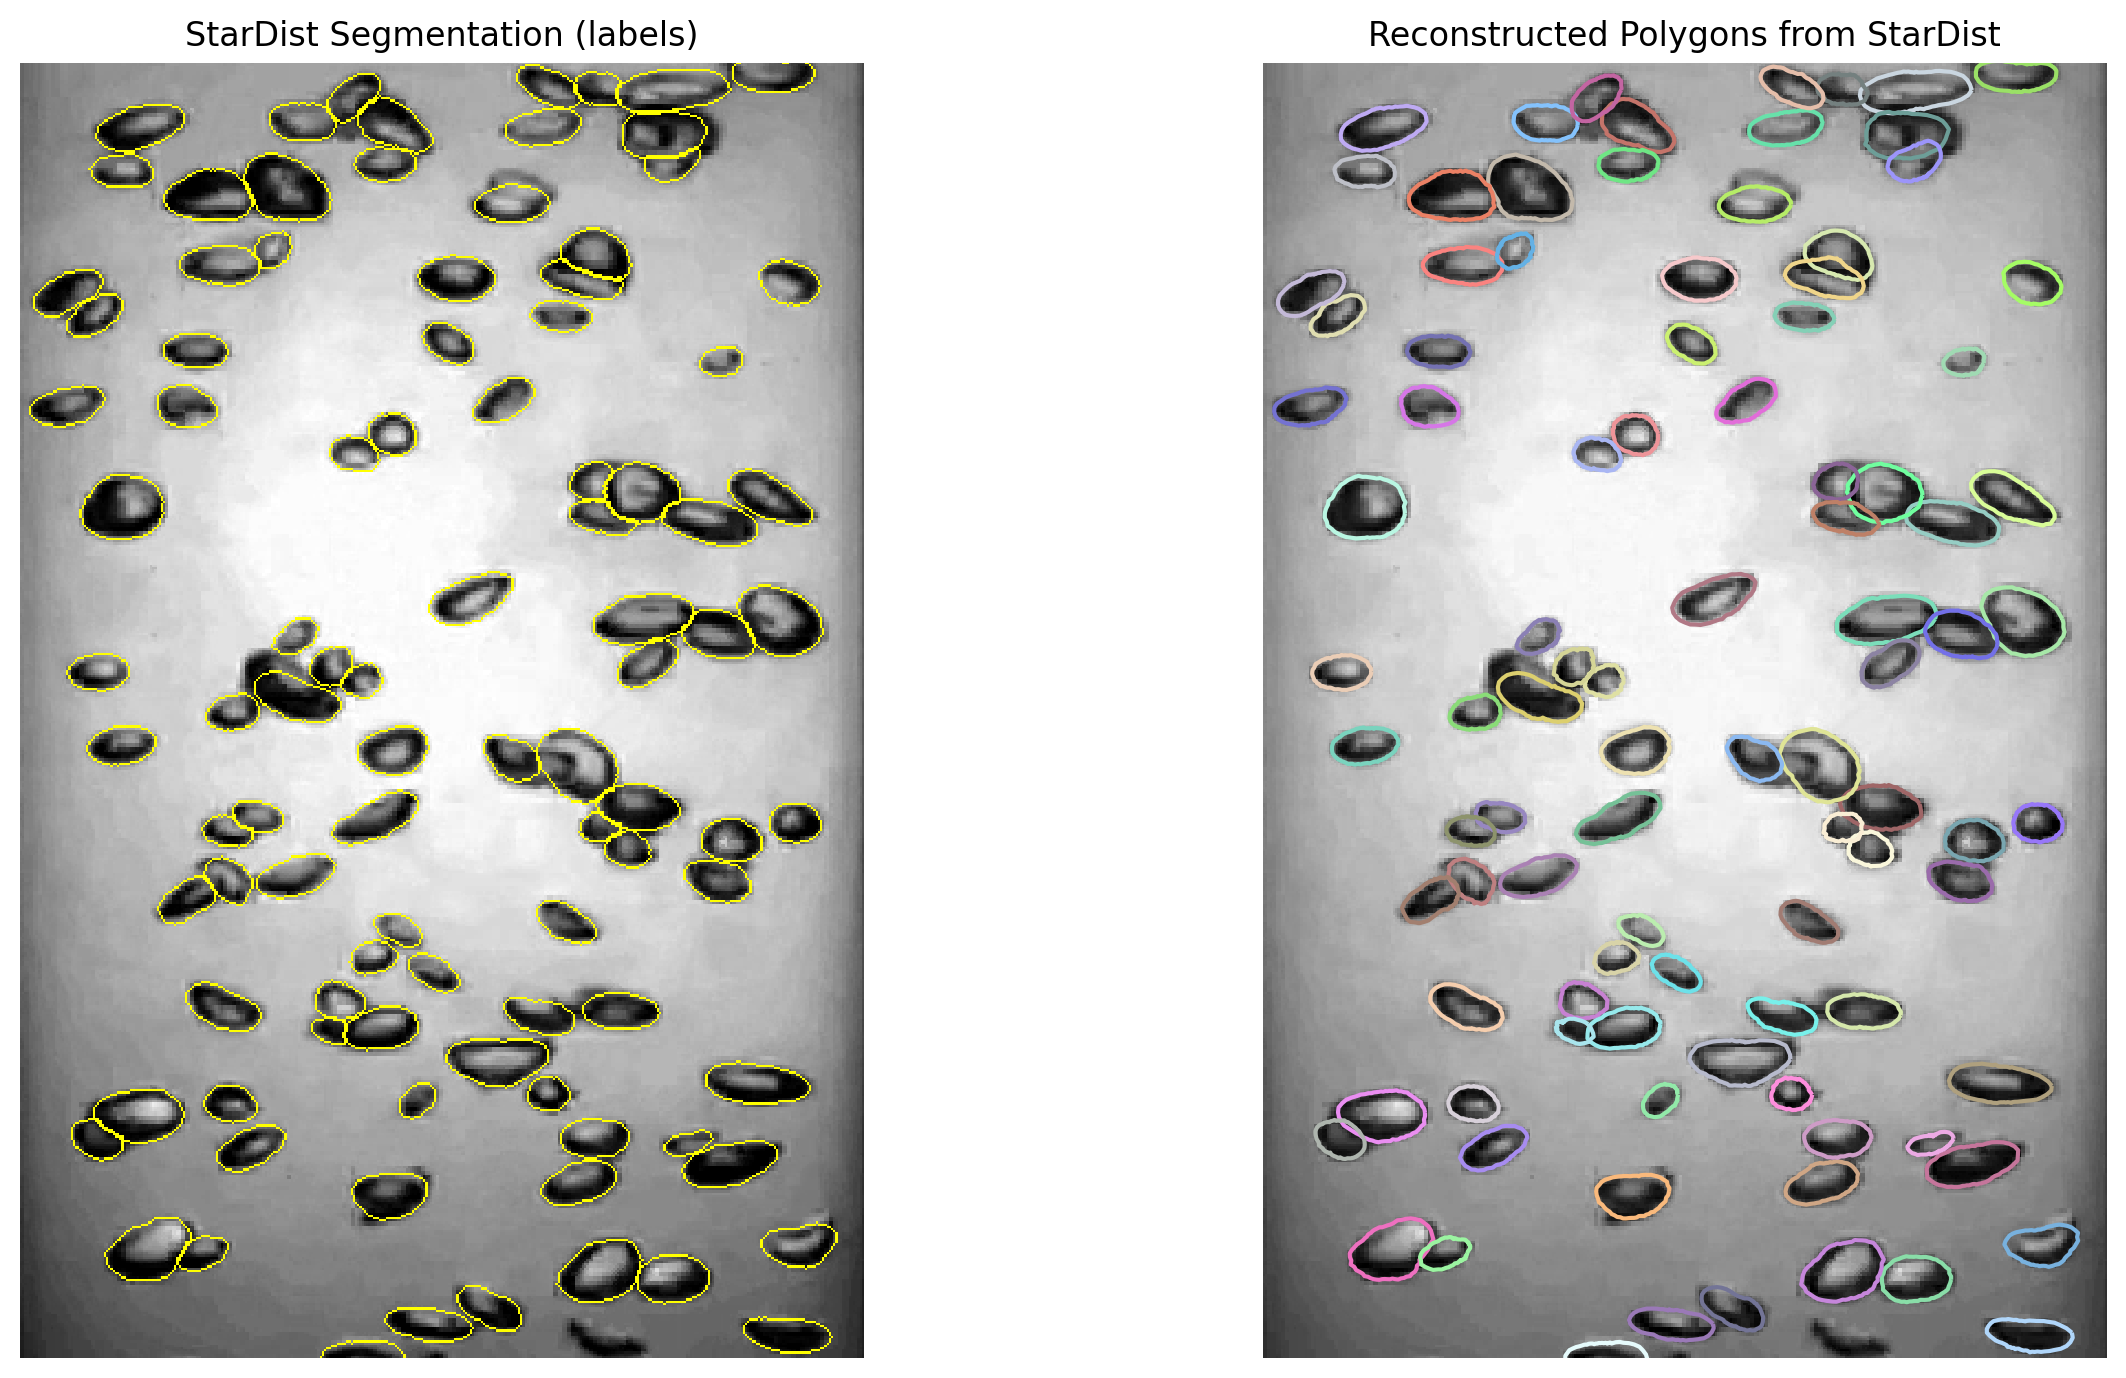

In [ ]:
import numpy as np
from skimage.draw import polygon
from skimage.segmentation import mark_boundaries
from matplotlib.patches import Polygon as MatplotlibPolygon



# Main code
Metric=6.7E-5 # Size of an image pixel in m 
boolplot=True # Use this for visual inspection.
useRDC=True # Switch on to use the RDC method, otherwise ellipse fitting will be used.

ImgDir=base_dir+'/Examples/43.png'

x=load_img(ImgDir)
X=normalize(x if x.ndim==2 else x[...,0], 1,99.8, axis=(0,1))
labels,details=modelSD.predict_instances(X,verbose=False)

coords = details["coord"]      # danh sách polygon
points = details["points"]     # tâm các bubble


# -----------------------------
# 4. Vẽ kết quả
# -----------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# ----- (A) ẢNH SEGMENTATION -------
ax[0].set_title("StarDist Segmentation (labels)")
ax[0].imshow(mark_boundaries(X, labels))
ax[0].axis("off")


# ----- (B) ẢNH RECONSTRUCT POLYGON -------
ax[1].set_title("Reconstructed Polygons from StarDist")
ax[1].imshow(X, cmap="gray")

# Debug: In thông tin về coords
print(f"Type of coords: {type(coords)}")
print(f"Shape of coords: {coords.shape if isinstance(coords, np.ndarray) else 'N/A'}")
print(f"Dtype of coords: {coords.dtype if isinstance(coords, np.ndarray) else 'N/A'}")

# StarDist có thể trả về coords dạng numpy array với shape (N, 2, M) hoặc (N, M, 2)
# trong đó N là số lượng polygon, M là số điểm trong mỗi polygon
if isinstance(coords, np.ndarray):
    if coords.ndim == 3:
        if coords.shape[1] == 2 and coords.shape[2] >= 2:
            # Shape (N, 2, M) - cần transpose thành (N, M, 2)
            # coords[i] có shape (2, M), cần chuyển thành (M, 2)
            coords_list = [coords[i].T for i in range(coords.shape[0])]
            print(f"Detected 3D array (N,2,M): {coords.shape[0]} polygons, each with {coords.shape[2]} points")
        elif coords.shape[2] == 2:
            # Shape (N, M, 2) - mỗi polygon là một mảng 2D
            coords_list = [coords[i] for i in range(coords.shape[0])]
            print(f"Detected 3D array (N,M,2): {coords.shape[0]} polygons, each with up to {coords.shape[1]} points")
        else:
            coords_list = []
    elif coords.ndim == 2:
        if coords.shape[1] == 2:
            # Có thể là một mảng duy nhất với tất cả các điểm
            # Hoặc có thể là list of arrays trong object dtype
            if coords.dtype == object:
                coords_list = [np.array(p) for p in coords]
                print(f"Detected 2D object array: {len(coords_list)} polygons")
            else:
                # Could be a polygon duy nhất
                coords_list = [coords]
                print(f"Detected 2D array as single polygon: {coords.shape[0]} points")
        else:
            coords_list = []
    elif coords.dtype == object:
        # Object array - mỗi phần tử là một mảng
        coords_list = [np.array(p) for p in coords.flatten() if isinstance(p, (np.ndarray, list))]
        print(f"Detected object array: {len(coords_list)} polygons")
    else:
        coords_list = []
elif isinstance(coords, dict):
    coords_list = list(coords.values())
elif isinstance(coords, (list, tuple)):
    coords_list = [np.array(p) for p in coords]
else:
    coords_list = []

print(f"Number of polygons to draw: {len(coords_list)}")
if len(coords_list) > 0:
    print(f"First polygon shape: {coords_list[0].shape if hasattr(coords_list[0], 'shape') else type(coords_list[0])}")

# Vẽ từng polygon độc lập
from matplotlib.collections import LineCollection

segments = []
colors = []

for idx, poly in enumerate(coords_list):
    poly = np.array(poly)
    if len(poly) > 0:
        # Đảm bảo poly có shape đúng (N, 2)
        if poly.ndim == 1:
            continue
        if poly.ndim == 2 and poly.shape[1] >= 2:
            # Loại bỏ các điểm NaN hoặc không hợp lệ
            valid_mask = ~(np.isnan(poly[:, 0]) | np.isnan(poly[:, 1]) | 
                          np.isinf(poly[:, 0]) | np.isinf(poly[:, 1]))
            poly = poly[valid_mask]
            
            if len(poly) < 3:  # Cần ít nhất 3 điểm để tạo polygon
                continue
            
            # StarDist trả về tọa độ dạng (y, x) = (row, col)
            # Matplotlib plot cần (x, y) = (col, row)
            x_coords = poly[:, 1]  # cột (x)
            y_coords = poly[:, 0]  # hàng (y)
            
            # Đóng polygon bằng cách thêm điểm đầu vào cuối
            x_coords = np.append(x_coords, x_coords[0])
            y_coords = np.append(y_coords, y_coords[0])
            
            # Tạo segment với shape (N, 2) cho LineCollection
            segment = np.column_stack([x_coords, y_coords])
            segments.append(segment)
            
            # Tạo màu sáng để dễ nhìn (RGB 0-1)
            random_color = tuple(np.random.choice(range(100, 256), size=3) / 255)
            colors.append(random_color)

# Vẽ tất cả polygon cùng lúc với LineCollection
if segments:
    lc = LineCollection(segments, colors=colors, linewidths=1.5, linestyles='solid')
    ax[1].add_collection(lc)
    print(f"Successfully drew {len(segments)} polygons")
else:
    print("No polygons to draw!")

ax[1].axis("off")

# ==================== TÍNH DIỆN TÍCH CÁC BỌT KHÍ ====================
def calculate_polygon_area(polygon_coords, metric):
    """Tính diện tích polygon bằng công thức Shoelace"""
    if len(polygon_coords) < 3:
        return 0.0
    x = polygon_coords[:, 1]  # cột (x)
    y = polygon_coords[:, 0]  # hàng (y)
    area_pixels = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    area_m2 = area_pixels * (metric ** 2)
    return area_m2

def calculate_area_from_labels(labels, label_id, metric):
    """Tính diện tích từ segmentation mask (đếm số pixel)"""
    pixel_count = np.sum(labels == label_id)
    area_m2 = pixel_count * (metric ** 2)
    return area_m2

# Tính diện tích cho mỗi bọt khí
bubble_areas = []
bubble_info = []

print("\n" + "="*60)
print("=== DIỆN TÍCH CÁC BỌT KHÍ ===")
print("="*60)

for idx, poly in enumerate(coords_list):
    poly = np.array(poly)
    if len(poly) > 0 and poly.ndim == 2 and poly.shape[1] >= 2:
        valid_mask = ~(np.isnan(poly[:, 0]) | np.isnan(poly[:, 1]) | 
                      np.isinf(poly[:, 0]) | np.isinf(poly[:, 1]))
        poly_valid = poly[valid_mask]
        
        if len(poly_valid) >= 3:
            area_from_polygon = calculate_polygon_area(poly_valid, Metric)
            label_id = idx + 1
            
            # Tính tâm từ polygon (hoặc dùng từ StarDist nếu có)
            if points is not None and len(points) > idx:
                # Sử dụng tâm từ StarDist
                center_y = points[idx][0]  # hàng (y)
                center_x = points[idx][1]  # cột (x)
            else:
                # Tính tâm từ polygon
                center_y = np.mean(poly_valid[:, 0])  # hàng (y)
                center_x = np.mean(poly_valid[:, 1])  # cột (x)
            
            # Vẽ số label vào tâm trên ax[1]
            ax[1].text(center_x, center_y, str(label_id), 
                      fontsize=8, fontweight='bold',
                      color='white', ha='center', va='center',
                      bbox=dict(boxstyle='circle', facecolor='black', 
                               edgecolor='white', linewidth=0.5, alpha=0.7))

            # Sử dụng diện tích từ labels nếu có, nếu không dùng từ polygon
            if label_id <= np.max(labels):
                area_from_labels = calculate_area_from_labels(labels, label_id, Metric)
                area_m2 = area_from_labels
            else:
                area_m2 = area_from_polygon
            
            bubble_areas.append(area_m2)
            bubble_info.append({
                'label_id': label_id,
                'area_m2': area_m2,
                'num_points': len(poly_valid)
            })
            print(f"Bọt khí {label_id:3d}: {area_m2*1e6:8.2f} mm² ({area_m2*1e12:10.2f} µm²)")

if bubble_areas:
    print("-"*60)
    print(f"Tổng số bọt khí:        {len(bubble_areas)}")
    print(f"Tổng diện tích:         {sum(bubble_areas)*1e6:.2f} mm²")
    print(f"Diện tích trung bình:   {np.mean(bubble_areas)*1e6:.2f} mm²")
    print(f"Diện tích lớn nhất:     {np.max(bubble_areas)*1e6:.2f} mm²")
    print(f"Diện tích nhỏ nhất:     {np.min(bubble_areas)*1e6:.2f} mm²")
    print(f"Độ lệch chuẩn:          {np.std(bubble_areas)*1e6:.2f} mm²")
    print("="*60)

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


=== DỰ ĐOÁN PHẦN KHÔNG NHÌN THẤY TỪ STARdist ===
Keys trong details: ['coord', 'points', 'prob']
Số lượng bọt khí: 78

Số lượng polygon: 78

=== SO SÁNH DIỆN TÍCH: GỐC vs ĐÃ KHÔI PHỤC ===
ID    Gốc (mm²)       Khôi phục (mm²)      Tăng (%)       
--------------------------------------------------------------------------------
1     2.87            2.87                 -0.02          
2     3.51            3.51                 -0.04          
3     2.89            2.89                 -0.04          
4     2.90            2.99                 2.97           
5     3.45            3.83                 10.93          
6     3.67            3.67                 -0.02          
7     3.13            3.37                 7.57           
8     3.59            3.87                 7.65           
9     3.94            4.28                 8.63           
10    2.38            2.62                 9.99           
11    3.67            3.67                 -0.13          
12    1.71            1

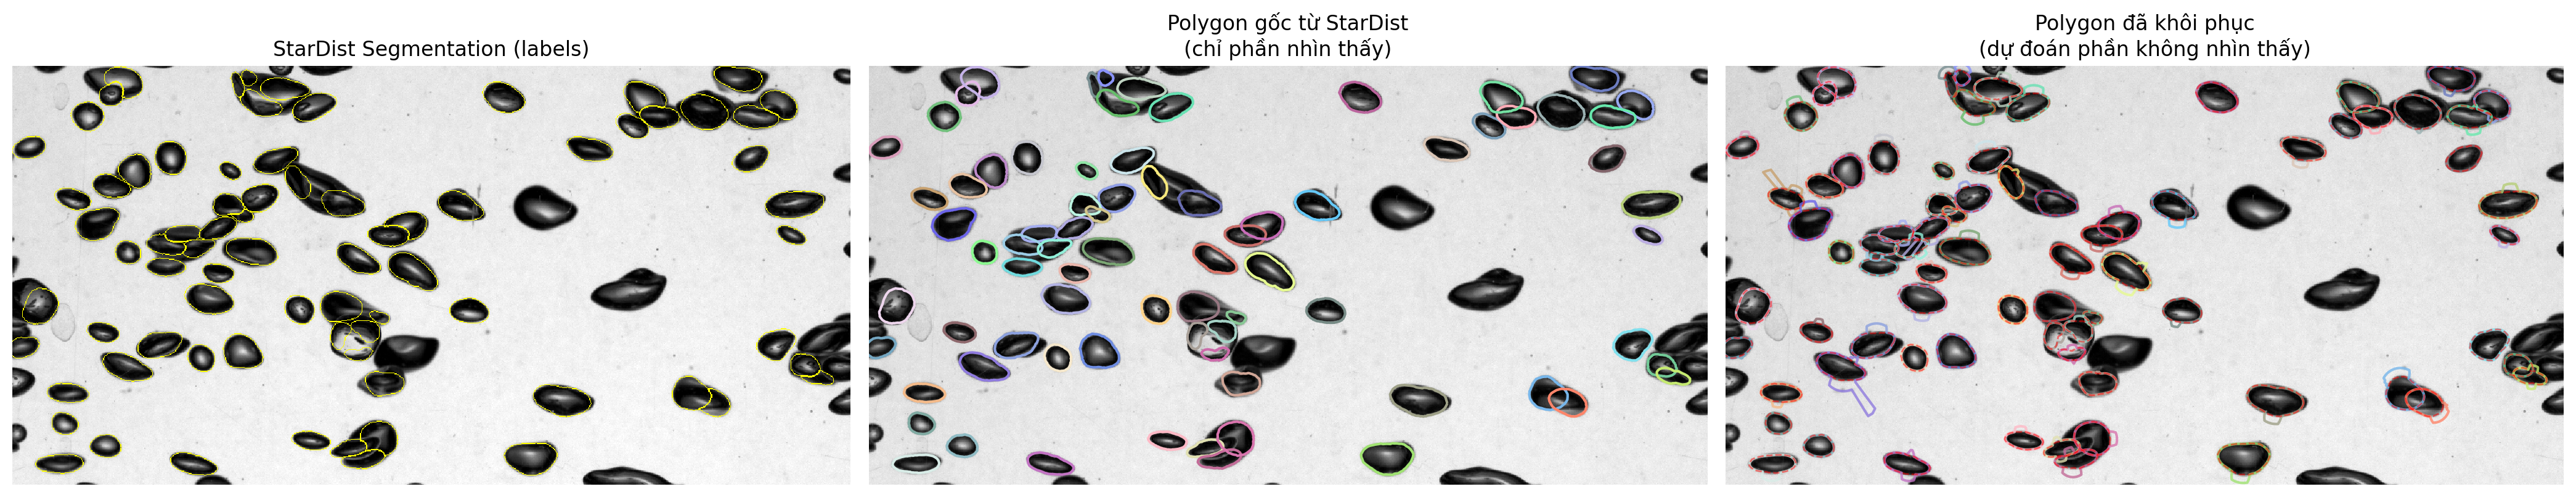

In [3]:
import numpy as np
from skimage.segmentation import mark_boundaries
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d

# ==================== DỰ ĐOÁN PHẦN KHÔNG NHÌN THẤY CHỈ DÙNG STARdist ====================
# Phương pháp: Sử dụng hình dạng star-convex và nội suy radial distance

Metric = 6.7E-5  # Size of an image pixel in m
ImgDir = base_dir + '/Examples/358.png'

# Load và normalize ảnh
x = load_img(ImgDir)
X = normalize(x if x.ndim == 2 else x[..., 0], 1, 99.8, axis=(0, 1))

# Prediction với StarDist
labels, details = modelSD.predict_instances(X, verbose=False)

# Lấy thông tin từ StarDist
coords = details["coord"]      # danh sách polygon từ StarDist
points = details["points"]     # tâm các bubble từ StarDist

print("=== DỰ ĐOÁN PHẦN KHÔNG NHÌN THẤY TỪ STARdist ===")
print(f"Keys trong details: {list(details.keys())}")
print(f"Số lượng bọt khí: {len(coords) if hasattr(coords, '__len__') else 'N/A'}")

# ==================== HÀM TÍNH DIỆN TÍCH ====================
def calculate_polygon_area(polygon_coords, metric):
    """Tính diện tích polygon bằng công thức Shoelace"""
    if len(polygon_coords) < 3:
        return 0.0
    x = polygon_coords[:, 1]  # cột (x)
    y = polygon_coords[:, 0]  # hàng (y)
    area_pixels = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    area_m2 = area_pixels * (metric ** 2)
    return area_m2

# ==================== HÀM DỰ ĐOÁN PHẦN BỊ CHE ====================
def find_intersection_with_polygon(center, angle, polygon_coords, max_dist=1000):
    """
    Tìm điểm giao của tia từ tâm với polygon
    
    Parameters:
    -----------
    center : tuple
        Tâm (y, x)
    angle : float
        Góc của tia (radian)
    polygon_coords : np.array
        Tọa độ polygon (y, x)
    max_dist : float
        Khoảng cách tối đa để tìm giao điểm
    
    Returns:
    --------
    distance : float
        Khoảng cách từ tâm đến điểm giao, hoặc max_dist nếu không tìm thấy
    """
    center_y, center_x = center
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    
    min_dist = max_dist
    
    # Duyệt qua các cạnh của polygon
    for i in range(len(polygon_coords)):
        p1 = polygon_coords[i]
        p2 = polygon_coords[(i + 1) % len(polygon_coords)]
        
        # Tọa độ của 2 điểm
        y1, x1 = p1[0], p1[1]
        y2, x2 = p2[0], p2[1]
        
        # Vector của cạnh
        dx_edge = x2 - x1
        dy_edge = y2 - y1
        
        # Vector của tia
        dx_ray = cos_a
        dy_ray = sin_a
        
        # Giải hệ phương trình để tìm giao điểm
        # Tia: (x, y) = (center_x, center_y) + t * (cos_a, sin_a)
        # Cạnh: (x, y) = (x1, y1) + s * (dx_edge, dy_edge)
        
        # Ma trận hệ số
        det = dx_ray * dy_edge - dy_ray * dx_edge
        
        if abs(det) < 1e-10:  # Song song
            continue
        
        # Tính t và s
        t = ((x1 - center_x) * dy_edge - (y1 - center_y) * dx_edge) / det
        s = ((x1 - center_x) * dy_ray - (y1 - center_y) * dx_ray) / det
        
        # Kiểm tra giao điểm nằm trên cả tia và cạnh
        if t > 0 and 0 <= s <= 1:
            dist = t
            if dist < min_dist:
                min_dist = dist
    
    return min_dist

def reconstruct_hidden_parts(polygon_coords, center, n_rays=64, threshold_ratio=0.7):
    """
    Dự đoán phần bị che bằng cách vẽ 64 tia từ tâm và phát hiện tia bị che
    
    Parameters:
    -----------
    polygon_coords : np.array
        Tọa độ polygon hiện có (y, x) - chỉ phần nhìn thấy
    center : tuple
        Tâm của bọt khí (y, x)
    n_rays : int
        Số lượng tia (64)
    threshold_ratio : float
        Ngưỡng để phát hiện tia bị che (nếu khoảng cách < threshold_ratio * trung bình)
    
    Returns:
    --------
    reconstructed_coords : np.array
        Polygon đầy đủ đã được khôi phục (y, x)
    num_hidden_rays : int
        Số lượng tia bị che
    """
    if len(polygon_coords) < 3:
        return polygon_coords, 0
    
    center_y, center_x = center
    
    # Tạo 64 tia đều nhau từ tâm
    angles = np.linspace(0, 2*np.pi, n_rays, endpoint=False)
    
    # Tìm khoảng cách từ tâm đến biên cho mỗi tia
    distances = []
    max_search_dist = np.sqrt((polygon_coords[:, 0].max() - polygon_coords[:, 0].min())**2 + 
                              (polygon_coords[:, 1].max() - polygon_coords[:, 1].min())**2) * 2
    
    for angle in angles:
        dist = find_intersection_with_polygon(center, angle, polygon_coords, max_search_dist)
        distances.append(dist)
    
    distances = np.array(distances)
    
    # Tính trung bình khoảng cách của các tia không bị che
    # Giả sử tia bị che có khoảng cách < threshold_ratio * trung bình
    mean_dist = np.mean(distances)
    threshold = threshold_ratio * mean_dist
    
    # Phát hiện các tia bị che
    hidden_mask = distances < threshold
    
    # Tính trung bình của các tia không bị che
    if np.any(~hidden_mask):
        mean_visible_dist = np.mean(distances[~hidden_mask])
    else:
        # Nếu tất cả đều bị che, dùng trung bình chung
        mean_visible_dist = mean_dist
    
    # Thay thế khoảng cách của các tia bị che bằng trung bình của tia không bị che
    reconstructed_distances = distances.copy()
    reconstructed_distances[hidden_mask] = mean_visible_dist
    
    # Làm mịn để tránh biến động lớn (tùy chọn)
    reconstructed_distances = uniform_filter1d(reconstructed_distances, size=3, mode='wrap')
    
    # Tạo tọa độ polygon đầy đủ từ 64 tia
    reconstructed_coords = np.zeros((n_rays, 2))
    for i, (angle, dist) in enumerate(zip(angles, reconstructed_distances)):
        reconstructed_coords[i, 0] = center_y + dist * np.sin(angle)  # y
        reconstructed_coords[i, 1] = center_x + dist * np.cos(angle)  # x
    
    num_hidden_rays = np.sum(hidden_mask)
    return reconstructed_coords, num_hidden_rays

# ==================== XỬ LÝ COORDS ====================
if isinstance(coords, np.ndarray) and coords.ndim == 3:
    if coords.shape[1] == 2 and coords.shape[2] >= 2:
        coords_list = [coords[i].T for i in range(coords.shape[0])]
    elif coords.shape[2] == 2:
        coords_list = [coords[i] for i in range(coords.shape[0])]
    else:
        coords_list = []
else:
    coords_list = [np.array(p) for p in coords] if isinstance(coords, (list, tuple)) else []

print(f"\nSố lượng polygon: {len(coords_list)}")

# ==================== VẼ KẾT QUẢ ====================
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

# ----- (A) ẢNH SEGMENTATION -------
ax[0].set_title("StarDist Segmentation (labels)")
ax[0].imshow(mark_boundaries(X, labels))
ax[0].axis("off")

# ----- (B) POLYGON GỐC TỪ STARdist (chỉ phần nhìn thấy) -------
ax[1].set_title("Polygon gốc từ StarDist\n(chỉ phần nhìn thấy)")
ax[1].imshow(X, cmap="gray")

# ----- (C) POLYGON ĐÃ KHÔI PHỤC (dự đoán phần bị che) -------
ax[2].set_title("Polygon đã khôi phục\n(dự đoán phần không nhìn thấy)")
ax[2].imshow(X, cmap="gray")

# Vẽ các polygon
segments_original = []
segments_reconstructed = []
colors = []
bubble_areas_original = []
bubble_areas_reconstructed = []

for idx, poly in enumerate(coords_list):
    poly = np.array(poly)
    if len(poly) > 0 and poly.ndim == 2 and poly.shape[1] >= 2:
        # Loại bỏ các điểm NaN hoặc không hợp lệ
        valid_mask = ~(np.isnan(poly[:, 0]) | np.isnan(poly[:, 1]) | 
                      np.isinf(poly[:, 0]) | np.isinf(poly[:, 1]))
        poly_valid = poly[valid_mask]
        
        if len(poly_valid) >= 3:
            # Tính diện tích polygon gốc
            area_original = calculate_polygon_area(poly_valid, Metric)
            bubble_areas_original.append(area_original)
            
            # Lấy tâm từ StarDist hoặc tính từ polygon
            if points is not None and len(points) > idx:
                center = (points[idx][0], points[idx][1])  # (y, x)
            else:
                center = (np.mean(poly_valid[:, 0]), np.mean(poly_valid[:, 1]))
            
            # Khôi phục phần bị che
            poly_reconstructed, num_hidden = reconstruct_hidden_parts(poly_valid, center, n_rays=64, threshold_ratio=0.7)
            
            # Tính diện tích polygon đã khôi phục
            area_reconstructed = calculate_polygon_area(poly_reconstructed, Metric)
            bubble_areas_reconstructed.append(area_reconstructed)
            
            # Tạo màu ngẫu nhiên
            random_color = tuple(np.random.choice(range(100, 256), size=3) / 255)
            colors.append(random_color)
            
            # Vẽ polygon gốc (ax[1])
            x_coords_orig = poly_valid[:, 1]
            y_coords_orig = poly_valid[:, 0]
            x_coords_orig = np.append(x_coords_orig, x_coords_orig[0])
            y_coords_orig = np.append(y_coords_orig, y_coords_orig[0])
            segment_orig = np.column_stack([x_coords_orig, y_coords_orig])
            segments_original.append(segment_orig)
            
            # Vẽ polygon đã khôi phục (ax[2])
            x_coords_rec = poly_reconstructed[:, 1]
            y_coords_rec = poly_reconstructed[:, 0]
            x_coords_rec = np.append(x_coords_rec, x_coords_rec[0])
            y_coords_rec = np.append(y_coords_rec, y_coords_rec[0])
            segment_rec = np.column_stack([x_coords_rec, y_coords_rec])
            segments_reconstructed.append(segment_rec)
            
            # Vẽ số label vào tâm
            label_id = idx + 1
            x_center = center[1]  # cột (x)
            y_center = center[0]  # hàng (y)
            
            # for a in [ax[1], ax[2]]:
            #     a.text(x_center, y_center, str(label_id), 
            #           fontsize=8, fontweight='bold',
            #           color='white', ha='center', va='center',
            #           bbox=dict(boxstyle='circle', facecolor='black', 
            #                    edgecolor='white', linewidth=0.5, alpha=0.5))

# Vẽ polygon gốc
if segments_original:
    lc_orig = LineCollection(segments_original, colors=colors, linewidths=1.5, linestyles='solid')
    ax[1].add_collection(lc_orig)

# Vẽ polygon đã khôi phục
if segments_reconstructed:
    lc_rec = LineCollection(segments_reconstructed, colors=colors, linewidths=1.5, linestyles='solid', alpha=0.8)
    ax[2].add_collection(lc_rec)
    # Vẽ thêm polygon gốc bằng nét đứt để so sánh
    lc_orig_dashed = LineCollection(segments_original, colors='red', linewidths=1.0, 
                                    linestyles='dashed', alpha=0.5)
    ax[2].add_collection(lc_orig_dashed)

for a in [ax[1], ax[2]]:
    a.axis("off")

# ==================== IN KẾT QUẢ ====================
print("\n" + "="*80)
print("=== SO SÁNH DIỆN TÍCH: GỐC vs ĐÃ KHÔI PHỤC ===")
print("="*80)
print(f"{'ID':<5} {'Gốc (mm²)':<15} {'Khôi phục (mm²)':<20} {'Tăng (%)':<15}")
print("-"*80)

for idx in range(len(bubble_areas_original)):
    area_orig = bubble_areas_original[idx] * 1e6
    area_rec = bubble_areas_reconstructed[idx] * 1e6
    increase = ((area_rec - area_orig) / area_orig * 100) if area_orig > 0 else 0
    print(f"{idx+1:<5} {area_orig:<15.2f} {area_rec:<20.2f} {increase:<15.2f}")

if bubble_areas_original:
    print("-"*80)
    print(f"{'Tổng số bọt khí:':<30} {len(bubble_areas_original)}")
    print(f"{'Tổng diện tích gốc:':<30} {sum(bubble_areas_original)*1e6:.2f} mm²")
    print(f"{'Tổng diện tích khôi phục:':<30} {sum(bubble_areas_reconstructed)*1e6:.2f} mm²")
    avg_increase = np.mean([(bubble_areas_reconstructed[i] - bubble_areas_original[i]) / 
                            bubble_areas_original[i] * 100 
                            for i in range(len(bubble_areas_original)) if bubble_areas_original[i] > 0])
    print(f"{'Tăng trung bình:':<30} {avg_increase:.2f}%")
    print("="*80)
    print("\nLưu ý: Phương pháp này vẽ 64 tia từ tâm, phát hiện tia bị che")
    print("       (khoảng cách ngắn hơn 70% trung bình), và thay thế bằng")
    print("       trung bình của các tia không bị che.")

plt.tight_layout()
plt.show()


### Example: Evaluating a set of images
This example shows how to evalute a set of images and saving the results.

In [ ]:
from pathlib import Path


Metric=7.7E-5 # Size of an image pixel in m
useRDC=True # Switch on to use the RDC method, otherwise ellipse fitting will be used.
writeOutSingle=False # Toggle this parameter to save the results for every single image.

ImgDir=base_dir+'/Examples/'
Imgs=sorted(pathlib.Path(ImgDir).glob('*.jpg'))

OutDir=ImgDir+'Results/'
if os.path.isdir(OutDir)==False:
    os.mkdir(OutDir) 

AllBubbles=[] 
for i,img in enumerate(tqdm[Path](Imgs,desc='Progress')):
    x=load_img(img)
    X=normalize(x if x.ndim==2 else x[...,0], 1,99.8, axis=(0,1))
    imgMask,imgIntersec=createLabelUNet(X,2,netMask,512,300,ctxMask=ctx)
    labels,_=combinedPrediction(X,modelSD,imgMask,imgIntersec)
    Bubbles=HiddenReco(labels,Metric,timestep=i,useRDC=useRDC,model=model)
    if writeOutSingle:
        SaveCSV_List(Bubbles,OutDir,img.name,header='X [px],Y [px],Diameter [m],Major [m],Minor [m], Timestep [-]')
    AllBubbles+=Bubbles
SaveCSV_List(AllBubbles,OutDir,'AllBubbles',header='X [px],Y [px],Diameter [m],Major [m],Minor [m], Timestep [-]')

Progress: 100%|██████████| 5/5 [00:36<00:00,  7.33s/it]


In [ ]:
# evaluate
import numpy as np
import matplotlib.pyplot as plt
from stardist import fill_label_holes, gputools_available, random_label_cmap
from stardist.models import StarDist2D, Config2D
from stardist.matching import matching_dataset
from tifffile import imread
import os
from csbdeep.utils import normalize
from glob import glob
from tqdm import tqdm
import json
from stardist.models import StarDist2D
from skimage.io import imread

lbl_cmap = random_label_cmap()
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl)
    al.set_title(lbl_title)
    plt.tight_layout()

RAW_DATA_FOLDER = '/kaggle/input'
MODEL_FOLDER = '/kaggle/working/models'
datarawName = 'data-v3'
# Paths to directories containing images and masks
image_folder = os.path.join(RAW_DATA_FOLDER, datarawName, 'origin_tif')
mask_folder = os.path.join(RAW_DATA_FOLDER, datarawName, 'mask_tif')
print(image_folder)
# Read paths to image and mask files
image_files = sorted(glob(os.path.join(image_folder, '*.tif')))
mask_files = sorted(glob(os.path.join(mask_folder, '*.tif')))

# Check number of image and mask files
assert len(image_files) == len(mask_files), "Number of images and masks do not match"

# Read data
X = list(map(imread, image_files))
Y = list(map(imread, mask_files))
print('number of images ok: %3d' % len(X))

# Check dimensions of images and masks
for x, y in zip(X, Y):
    assert x.shape == y.shape, "Image and mask must have the same dimensions"

# Axes to normalize independently (spatial axes: 0 and 1)
axis_norm = (0, 1)

# Normalize input data (X) by scaling pixels to 1% and 99.8% percentiles
X = [normalize(x, 1, 99.8, axis=axis_norm) for x in X]
# Fill holes in labels (Y) to ensure uninterrupted labels
Y = [fill_label_holes(y) for y in tqdm(Y)]

# Check data quantity, must have at least 2 samples
assert len(X) > 1, "not enough training data"

rng = np.random.RandomState(42)
# Permute indices of the entire dataset
ind = rng.permutation(len(X))

# Split data into train and validation sets, validation ratio is 15%
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

# Get train and validation data by indices
X_val, Y_val = [X[i] for i in ind_val], [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]

# Print number of images, training images, and validation images
print('number of images: %3d' % len(X))
print('training:       %3d' % len(X_trn))
print('validation:     %3d' % len(X_val))

Y_val_pred = [
    modelSD.predict_instances(
       x,
       n_tiles=model._guess_n_tiles(x),
       show_tile_progress=False
    )[0]
    for x in tqdm(X_val, desc="Predict val")
]

taus = [0.5,0.6,0.7,0.8,0.9]
stats = [
   matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False)
   for t in tqdm(taus, desc="Matching stats")
]
# print("Debug stats:")
# for i, tau in enumerate(taus):
#     s = stats[i]
#     print(f"Tau={tau}: precision={s.precision:.4f}, recall={s.recall:.4f}, tp={s.tp}, fp={s.fp}")
# if hasattr(s, '_asdict'):
#     print(f"  _asdict() available: {s._asdict()}")
# else:
#     print("  _asdict() NOT available - using direct attribute access")
ap_values = [
    (s.tp / (s.tp + s.fp + s.fn)) if (s.tp + s.fp + s.fn) > 0 else 0.0
    for s in stats
]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# for m in ('precision','recall','accuracy','f1',
#           'mean_true_score','mean_matched_score','panoptic_quality'):
#     ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.plot(taus, ap_values, 'o-', lw=2, label='AP', color='black')
ax1.set_xlabel(r'IoU threshold $\tau$'); ax1.set_ylabel('Metric value')
ax1.grid(True, alpha=0.3); ax1.legend()

for m in ('fp','tp','fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$'); ax2.set_ylabel('Number #')
ax2.grid(True, alpha=0.3); ax2.legend()

plt.tight_layout()
plt.show()
plt.close()
plot_img_label(X_val[1],Y_val[1], lbl_title="label GT")
plot_img_label(X_val[1],Y_val_pred[1], lbl_title="label Pred")

